# Example: Computing Synthetic AIA Emission

In [1]:
import os
import subprocess

import numpy as np
import astropy.units as u
import astropy.time
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from sunpy.util.metadata import MetaDict
import sunpy.sun.constants as const
import sunpy.coordinates.ephemeris

import synthesizAR
import synthesizAR.maps
from synthesizAR.interfaces import UniformHeating, EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels, make_aia_animation
from synthesizAR.extrapolate import PotentialField, peek_projections

%matplotlib inline

## Simulate Magnetogram
First, construct a fake magnetogram with a simple dipole configuration. If you're using a real observed magnetogram, these steps aren't needed.

In [2]:
def make_synthetic_map(xrange, yrange, shape, spots):
    # Setup array
    delta_x = xrange[1] - xrange[0]
    delta_y = yrange[1] - yrange[0]
    dx = delta_x/arr_grid_shape[0]
    dy = delta_y/arr_grid_shape[1]
    data = np.zeros(shape)
    xphysical, yphysical = np.meshgrid(np.arange(shape[0])*dx, np.arange(shape[1])*dy)
    # Add sunspots
    for spot in spots:
        if spot[0].unit is u.percent:
            pos = u.Quantity([spot[0][0].value/100.*delta_x + xrange[0],
                              spot[0][1].value/100.*delta_y + yrange[0]])
        else:
            pos = spot[0]
        if spot[1].unit is u.percent:
            sigma = spot[1].value/100.*delta_x
        else:
            sigma = spot[1]
        a_max   = spot[2].value
        xc_2 = (xphysical - pos[0] + xrange[0]).value**2.0
        yc_2 = (yphysical - pos[1] + yrange[0]).value**2.0
        data += a_max * np.exp( - ( (xc_2 + yc_2) / (2 * sigma.value**2)) )
        
    # Build metadata
    time_now = astropy.time.Time.now()
    observer = sunpy.coordinates.ephemeris.get_earth(time=time_now)
    meta = MetaDict({
        'telescop': 'fake_telescope',
        'instrume': 'fake_mag_imager',
        'detector': 'fake_detector',
        'bunit': 'Gauss',
        'ctype1': 'HPLN-TAN',
        'ctype2': 'HPLT-TAN',
        'hgln_obs': observer.lon.to(u.deg).value,
        'hglt_obs': observer.lat.to(u.deg).value,
        'cunit1': 'arcsec',
        'cunit2': 'arcsec',
        'crpix1': (shape[0] + 1)/2.,
        'crpix2': (shape[1] + 1)/2.,
        'cdelt1': delta_x.to(u.arcsec).value/shape[0],
        'cdelt2': delta_y.to(u.arcsec).value/shape[1],
        'crval1': ((xrange[0] + xrange[1])/2.).value,
        'crval2': ((yrange[0] + yrange[1])/2.).value,
        'dsun_obs': observer.radius.to(u.m).value,
        'dsun_ref': observer.radius.to(u.m).value,
        'rsun_ref': const.radius.to(u.m).value,
        'rsun_obs': ((const.radius/observer.radius).decompose() * u.radian).to(u.arcsec).value,
        't_obs': time_now.iso,
        'date-obs': time_now.iso,
    })
        
    plot_settings = {'cmap': 'hmimag',
                     'norm': matplotlib.colors.Normalize(vmin=-1.5e3, vmax=1.5e3)}
        
    return GenericMap(data, meta, plot_settings=plot_settings)

In [3]:
arr_grid_shape = [ 300, 300]
width_x,width_y = 300 * u.arcsec, 300 * u.arcsec
left_corner_x, left_corner_y = -150 * u.arcsec, -150 * u.arcsec
xrange = u.Quantity((left_corner_x, left_corner_x + width_x))
yrange = u.Quantity((left_corner_y, left_corner_y + width_y))
spots = [
    ( u.Quantity([60,50],u.percent), 5*u.percent,  1e3*u.Gauss),
    ( u.Quantity([40,50],u.percent), 5*u.percent,  -1e3*u.Gauss),
    #( u.Quantity([35,35],u.percent), 2*u.percent, -1e3*u.Gauss),
    #( u.Quantity([65,65],u.percent), 2*u.percent, -1e3*u.Gauss),
]
magnetogram = make_synthetic_map(xrange,yrange,arr_grid_shape,spots)

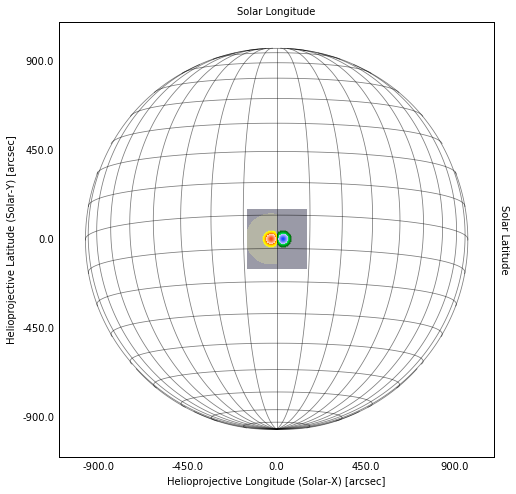

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection=magnetogram)
magnetogram.plot(title=False,axes=ax)
ax.grid(alpha=0)
magnetogram.draw_grid(color='k',grid_spacing=10*u.deg,axes=ax)
ax.plot_coord(
    SkyCoord(-1000 * u.arcsec, -1000 * u.arcsec, frame=magnetogram.coordinate_frame),
    color='w',marker='o',alpha=0,
)
ax.plot_coord(
    SkyCoord(1000 * u.arcsec, 1000 * u.arcsec, frame=magnetogram.coordinate_frame),
    color='w',marker='o',alpha=0,
)

In [5]:
magnetogram_resampled = magnetogram.resample((100,100) * u.pixel,)

## Extrapolate Field

In [6]:
potential_extrapolator = PotentialField(magnetogram_resampled, 0.3 * sunpy.sun.constants.radius, 100*u.pixel)

In [7]:
B_potential = potential_extrapolator.extrapolate()

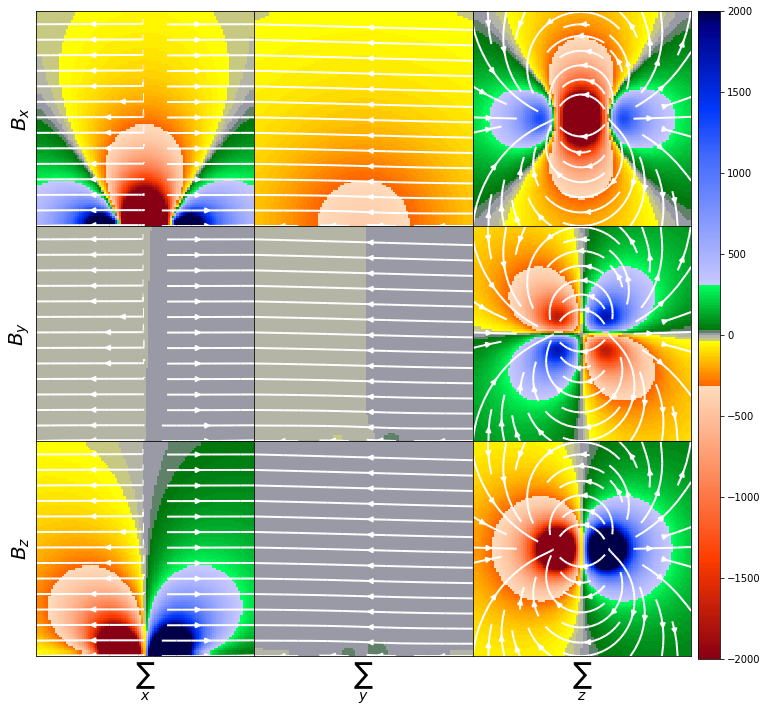

In [8]:
peek_projections(B_potential)

In [11]:
fieldlines = potential_extrapolator.trace_fieldlines(B_potential, 200,
                                                     close_threshold=0.05,
                                                     mask_threshold=0.1,
                                                     loop_length_range=[1e9,5e10]*u.cm)

yt : [INFO     ] 2018-03-03 23:18:50,194 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-03-03 23:18:50,195 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-03-03 23:18:50,195 Parameters: domain_left_edge          = [ -1.07312239e+10  -1.07367947e+10   0.00000000e+00]
yt : [INFO     ] 2018-03-03 23:18:50,196 Parameters: domain_right_edge         = [  1.07382277e+10   1.07438022e+10   2.08652400e+10]
yt : [INFO     ] 2018-03-03 23:18:50,197 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-03-03 23:18:50,713 AMRKDTree rebuilt, Final Volume: 9.622561e+30
Streamlining: 100%|██████████| 200/200 [00:00<00:00, 515.62it/s]
yt : [INFO     ] 2018-03-03 23:18:51,464 AMRKDTree rebuilt, Final Volume: 9.622561e+30
Streamlining: 100%|██████████| 53/53 [00:00<00:00, 533.30it/s]
yt : [INFO     ] 2018-03-03 23:18:51,824 AMRKDTree rebuilt, Final Volume: 9.622561e+30
Streamlining: 100%|██████████| 18/18 [00:00<00:00, 412.29it/s]
yt : [INFO     

FloatProgress(value=0.0)

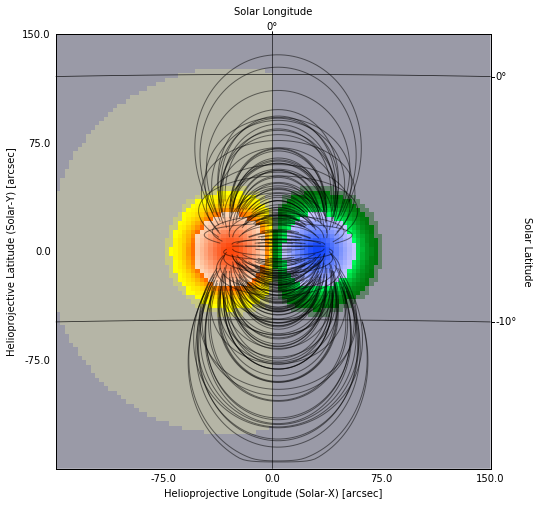

In [12]:
potential_extrapolator.peek(fieldlines,line_frequency=1)

## Build Active Region
Next, extrapolate a 3D magnetic field from the magnetogram and trace fieldlines through this volume.

In [13]:
active_region = synthesizAR.Field(magnetogram_resampled, fieldlines)

Text(0.5,0,'$L$ [Mm]')

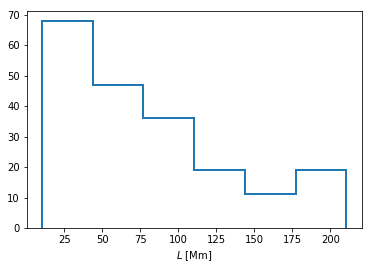

In [14]:
plt.hist([loop.full_length.to(u.Mm).value for loop in active_region.loops],bins='scott',histtype='step',lw=2);
plt.xlabel(r'$L$ [Mm]')

## Hydrodynamics
Now, we need to model the dynamics of each of our loops, defined geometrically by the strands we traced above, using some hydrodynamic model. In this case, we'll use the EBTEL model due to its efficiency.

In [24]:
class SingleEventModel(UniformHeating):
    @property
    def number_events(self):
        return 1
heating_options = {
                   'duration':200,
                   'average_waiting_time':1000,
                   'duration_rise':100,
                   'duration_decay':100,
                   'stress_level':0.1
                  }
heating_model = SingleEventModel(heating_options)

In [25]:
base_config = synthesizAR.util.InputHandler(
    '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml'
).lookup_vars()
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['force_single_fluid'] = False
base_config['heating']['partition'] = 1.
base_config['heating']['background'] = 1e-6

In [26]:
ebtel_interface = EbtelInterface(base_config,
                                 heating_model,
                                 '/Users/willbarnes/Desktop/synthesizAR_example/hydro_config',
                                 '/Users/willbarnes/Desktop/synthesizAR_example/hydro_results')

In [27]:
active_region.configure_loop_simulations(ebtel_interface)

FloatProgress(value=0.0)

In [28]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/Users/willbarnes/Documents/work/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [29]:
for loop in active_region.loops:
    ebtel_runner(loop)

In [30]:
active_region.load_loop_simulations(ebtel_interface,savefile='/Users/willbarnes/Desktop/synthesizAR_example/loop_parameters.h5')

FloatProgress(value=0.0)

Text(0.5,0,'$t$ [s]')

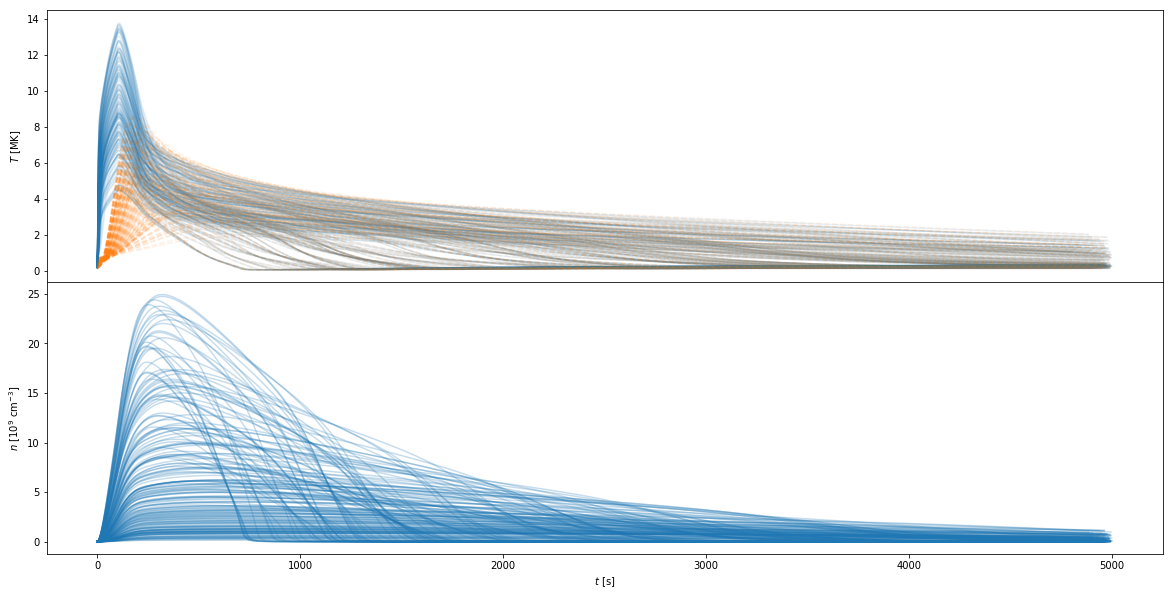

In [31]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in active_region.loops:
    axes[0].plot(loop.time,np.max(loop.electron_temperature.to(u.MK),axis=1),color='C0',alpha=0.1)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C1',ls='--',alpha=0.1)
    axes[1].plot(loop.time,np.mean(loop.density,axis=1)/1e9,color='C0',alpha=0.25)
#axes[0].set_xlim([0,base_config['total_time']])
#axes[0].set_ylim([0,20])
#axes[1].set_ylim([0,20])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

We can easily save the active region to be reloaded at a later time.

In [32]:
active_region.save('/Users/willbarnes/Desktop/synthesizAR_example/field_checkpoint')

And then restore the field like so.

In [ ]:
active_region = synthesizAR.Field.restore('/Users/willbarnes/Desktop/synthesizAR_example/field_checkpoint/')

## Forward Modeling
Finally, we can compute the emission as it would be observed by the AIA instrument on the SDO spacecraft. 

If we choose, we can also change the viewing angle by passing in a custom observer. If we do not pass one in, it will default to the location of the magnetogram observer (Earth in this case).

In [40]:
observer_coordinate = SkyCoord(lon=90.0 * u.deg,
                               lat=active_region.magnetogram.observer_coordinate.lat,
                               radius=active_region.magnetogram.observer_coordinate.radius,
                               frame='heliographic_stonyhurst')

In [41]:
aia = InstrumentSDOAIA([0,5000]*u.s,observer_coordinate=observer_coordinate)

In [42]:
observer = synthesizAR.Observer(active_region,[aia],)

In [43]:
observer.build_detector_files('/Users/willbarnes/Desktop/synthesizAR_example/', 0.5 * u.Mm)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


This step interpolates all of the quantities for each loop to the correct spatial and temporal resolution, calculates the intensity observed in each channel of the detector, and stores them all in a single file.

In [44]:
observer.flatten_detector_counts()

This final step uses the flattened coordinate and intensity information calculated from the previous step and builds a FITS file at each timestep (set by the instrument cadence) and for each channel of the detector. In this case, because AIA has a cadence of $\sim10$ s and a total of 6 EUV channels, we get $6\times5000/10=3000$ individual observations.

Note that if we would rather only produce files for a limited time range, we can reset the instrument observing time before this last step.

In [45]:
# optional
observer.instruments[0].observing_time = np.arange(0, 2500, aia.cadence.value) * u.s

In [46]:
observer.bin_detector_counts('/Users/willbarnes/Desktop/synthesizAR_example/')

## Visualize
We can use the plotting functionality provided by SunPy to plot our results. Note that our simulation output format is identical to that of actual observations, allowing us to process and analyze our results using the same techniques. For more info on handling and plotting maps in SunPy, see [the SunPy docs](http://sunpy.readthedocs.io/en/latest/guide/plotting.html#). 

As an example, below is our simulated active region after 1500 s of evolution as imaged by the 171 Å channel of AIA.

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/compositemap.py:418: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  "extent": list(m.xrange.value) + list(m.yrange.value),


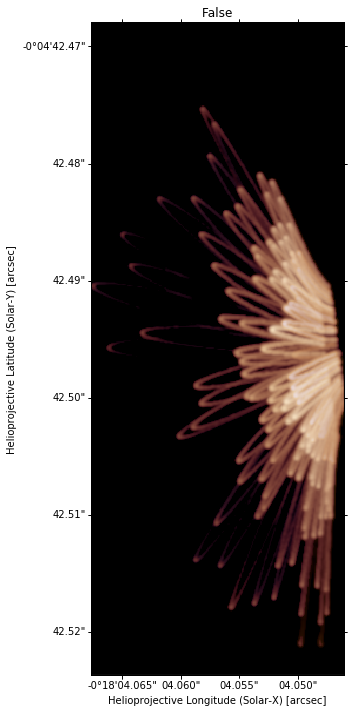

In [105]:
fig = plt.figure(figsize=(15,12))
m = Map('/Users/willbarnes/Desktop/synthesizAR_example/SDO_AIA/171/map_t000200.fits',
        '/Users/willbarnes/Desktop/synthesizAR_example/SDO_AIA/193/map_t000200.fits',
        '/Users/willbarnes/Desktop/synthesizAR_example/SDO_AIA/211/map_t000200.fits',
        composite=True
)
ax = fig.gca(projection=m.get_map(0))
#m.set_alpha(0,0.5)
m.set_alpha(1,0.75)
m.set_alpha(2,0.5)
# m.draw_grid(axes=ax, color='w', grid_spacing=10*u.deg)
im = m.plot(axes=ax,
            norm=matplotlib.colors.SymLogNorm(1e-6,vmin=0.1,vmax=5e2),
            title=False)

We can also use one of our built in plot helpers to plot all 6 channels in one plot for a given timestep.

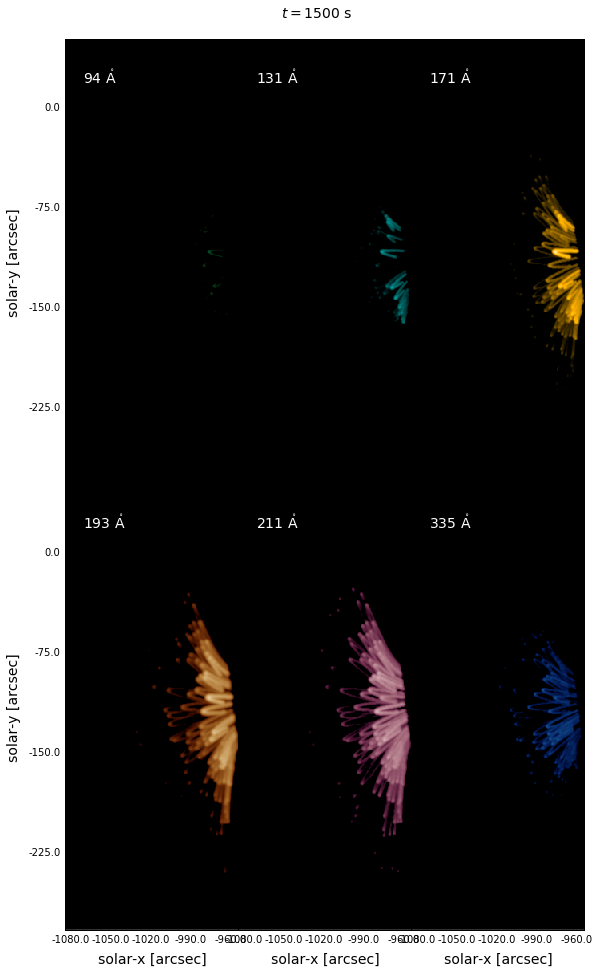

In [67]:
plot_aia_channels(aia,1500*u.s,
                  '/Users/willbarnes/Desktop/synthesizAR_example/',
                  figsize=(9.3,15))

Our make a movie over a given timerange (this can take a little bit, depending on how long you want the movie to be).

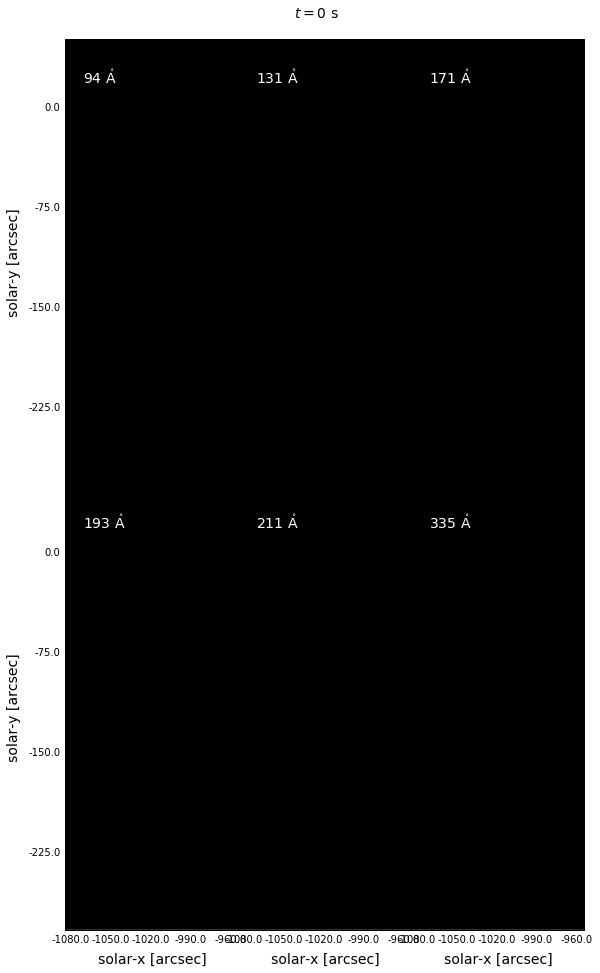

In [69]:
ani = make_aia_animation(aia, 0*u.s, 2500*u.s, '/Users/willbarnes/Desktop/synthesizAR_example/', figsize=(9.3,15))

In [70]:
ani.save('/Users/willbarnes/Desktop/sample_mov.mp4')